## Trying out some models:

### Data Preparation:

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib
import sqlite3
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, KFold, train_test_split

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

os.chdir("/Users/alexpapiu/Documents/Craiglist_Project")
import cl_pipeline

conn = sqlite3.connect("/Users/alexpapiu/Documents/Data/Craigslist/housing.db")
data = pd.read_sql("select * from cl_housing_clean", conn)
conn.close()

data = data.drop(["id"],axis = 1 )

#### Looking only at 1 bedrooms in San Francisco for now:

In [2]:
data = data[data.area == "San Francisco"]
data = data[data.int_bed == 1]
data = data[data.price < 10000]
data = data.reset_index()

In [3]:
data.head()

,index,datetime,geotag,has_image,has_map,name,num_bed,price,sq_feet,url,where,area,dayofweek,hour,int_bed,per_person
0,4987,2016-09-10 01:17:00,None,1,1,luxury condominium in the heart of soma,1.0,4200.0,840.0,http://sfbay.craigslist.org/sfc/apa/5774941537...,soma south beach,San Francisco,5,1,1.0,4200.0
1,5002,2016-09-10 00:26:00,None,1,1,newly renovated sf flat,1.0,3000.0,NaN,http://sfbay.craigslist.org/sfc/apa/5773135811...,downtown civic van ness,San Francisco,5,0,1.0,3000.0
2,5006,2016-09-09 23:57:00,None,1,1,charming sunny one bedroom,1.0,3500.0,550.0,http://sfbay.craigslist.org/sfc/apa/5774916007...,mission district,San Francisco,4,23,1.0,3500.0
3,5007,2016-09-09 23:55:00,None,1,1,luxury 1br at millennium tower-new carpet,1.0,3950.0,NaN,http://sfbay.craigslist.org/sfc/apa/5771043557...,soma south beach,San Francisco,4,23,1.0,3950.0
4,5008,2016-09-09 23:50:00,None,1,1,prime noe valley! extra-large studio. hardwood!,Studio,2500.0,550.0,http://sfbay.craigslist.org/sfc/apa/5728679315...,noe valley,San Francisco,4,23,1.0,2500.0


In [4]:
data["name"] = data["name"].str.replace("\d", "")

In [5]:
data.shape

(7889, 16)

In [6]:
cols = ["has_image", "has_map", "num_bed", "where", "hour", "dayofweek", "area"]
X_num = pd.get_dummies(data[cols])
y = data["price"]

In [7]:
X_num[:5]

,has_image,has_map,hour,dayofweek,num_bed_1.0,num_bed_Studio,where_1 henry adams st,where_1009 howard street,where_1888 geneva ave,where_18th 3rd ave,...,where_tenderloin,where_twin peaks diamond hts,where_usf panhandle,where_vallejo,where_van ness,where_visitacion valley,where_walnut creek,where_west portal forest hill,where_western addition,area_San Francisco
0,1,1,1,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,0,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,23,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,23,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1,23,4,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Training a model on the numeric and categorical features:

In [8]:
X_tr, X_val, y_tr, y_val = train_test_split(X_num, y, random_state = 3)

What RMSE would a naive prediction give:

In [9]:
naive_preds = np.repeat(np.mean(y_tr), X_val.shape[0])
np.sqrt(metrics.mean_squared_error(y_val, naive_preds))

851.3084469380052

In [12]:
model = Ridge(alpha = 1)
#model = RandomForestRegressor()
#model = Lasso()

In [13]:
model.fit(X_tr, y_tr)
#model.fit(X_tr, np.log1p(y_tr))

preds = model.predict(X_val)

In [14]:
np.sqrt(metrics.mean_squared_error(y_val, preds))
#np.sqrt(-cross_val_score(model, X_tr, y_tr, scoring = "mean_squared_error"))

618.82290870837403

In [14]:
#model = RandomForestRegressor(n_estimators=10)
#model.fit(X_tr, y_tr)b
#preds = model.predict(X_val)
#np.sqrt(metrics.mean_squared_error(y_val, preds))

In [10]:
from xgboost import XGBRegressor

In [11]:
model = XGBRegressor()

In [12]:
model.fit(X_tr, y_tr)
preds = model.predict(X_val)
np.sqrt(metrics.mean_squared_error(y_val, preds))


631.39315848136516

### Adding a bag of Words:

In [29]:
text = data["name"]

vect = CountVectorizer(stop_words="english", min_df=3)
X = vect.fit_transform(text)

X = pd.DataFrame(X.toarray(), columns = vect.get_feature_names())


In [30]:
X_all = pd.concat((X, X_num), 1)

X_all.shape

(7889, 1235)

In [31]:
X_tr, X_val, y_tr, y_val = train_test_split(X_all, y, random_state = 3)

In [32]:
#model = RandomForestRegressor(n_estimators=100)
#model.fit(X_tr, y_tr)
#preds = model.predict(X_val)
#np.sqrt(metrics.mean_squared_error(y_val, preds))

In [33]:
model = Ridge(alpha = 1)
model.fit(X_tr, y_tr)
preds = model.predict(X_val)
np.sqrt(metrics.mean_squared_error(y_val, preds))

456.51637855014036

### Interpreting the model:

In [20]:
vect = CountVectorizer(stop_words="english", min_df=10)
X = vect.fit_transform(text)
X = pd.DataFrame(X.toarray(), columns = vect.get_feature_names())
model = Ridge(alpha = 1)
model.fit(X, y)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [21]:
coeffs = pd.Series(model.coef_, index = X.columns)

In [22]:
small_big_coeffs = pd.concat([coeffs.sort_values().head(20), 
                              coeffs.sort_values().tail(20)])

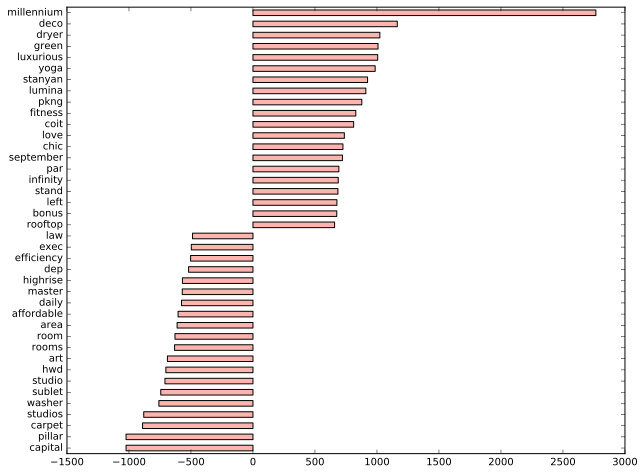

In [23]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

small_big_coeffs.plot.barh(colormap='Pastel1')